# How to use a saved model in Tensorflow 2.x

As a part of your machine-learning pipeline, training is not the only task you should be caring about. After all, the goal should be to deploy your machine learning in practice. In this article, you will learn how to use TensorFlow 2.x to save your trained model that can be used for making predictions.

There are a couple of things we can do while saving a model. Do we want to save the model weights and training parameters in every iteration (epochs), every once in a while, or once training has finished? We can use built-in callbacks just like we saw in my previous article to automatically save the model weights during the training process. Alternatively, we can also save the model weights and other necessary information once training has finished.
There are two main formats for saved models: One in native TensorFlow, and the other in HDF5 format since we are using TensorFlow through Keras API.

2.4.1


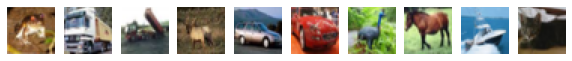

In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint



(X_train , y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

X_train = X_train[:1000]
X_test = X_test[:1000]
y_train = y_train[:1000]
y_test = y_test[:1000]


# Plot the first 10 CIFAR-10 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])

## Create a convolutional model

In [2]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## Create an instance of the model

In [36]:
model = get_new_model()
model.summary()



Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 8)         1160      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 7, 7, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                12576     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 14,514
Trainable params: 14,514
Non-trainable params: 0
__________________________________________________

 ## Accuracy function

In [37]:
def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.4f}%'.format(acc=test_acc*100))

In [38]:
get_test_accuracy(model, X_test, y_test)

accuracy: 10.3000%


A this point, there is just guessing accuracy of 10.5%

## Train Model with Checkpoints and save the model weights

In [47]:
checkpoint_dir = 'saved_model'
checkpoint = ModelCheckpoint(filepath=checkpoint_dir, 
                            frequency = "epoch",
                            save_weights_only = True,
                             verbose= True)

In [48]:
model.fit(X_train, y_train, callbacks=[checkpoint])

28/32 [=========================>....] - ETA: 0s - loss: 2.2968 - accuracy: 0.1384
Epoch 00001: saving model to saved_model
32/32 [==============================] - 0s 10ms/step - loss: 2.2932 - accuracy: 0.1390


##  Look at the Checkpoint Directory

In [51]:
!ls -lh {checkpoint_dir}

total 184K
-rw-r--r-- 1 ivory ivory   61 Jan 12 01:08 checkpoint
-rw-r--r-- 1 ivory ivory 174K Jan 12 01:08 cp.data-00000-of-00001
-rw-r--r-- 1 ivory ivory 2.0K Jan 12 01:08 cp.index


## Create a new model but load the same weights

In [42]:
model2 = get_new_model()
get_test_accuracy(model2, X_test, y_test)

accuracy: 10.4000%


In [43]:
model2.load_weights('saved_model/cp')
get_test_accuracy(model2, X_test, y_test)

accuracy: 10.4000%


In [54]:
!rm -rf {checkpoint_dir}

# Saving the entire model

In [64]:
checkpoint_dir = 'saved_model'
checkpoint = ModelCheckpoint(filepath=checkpoint_dir, 
                            frequency = "epoch",
                            save_weights_only = False,
                             verbose= True)

model.fit(X_train, y_train, callbacks=[checkpoint])

28/32 [=========================>....] - ETA: 0s - loss: 2.0745 - accuracy: 0.0971
Epoch 00001: saving model to saved_model
INFO:tensorflow:Assets written to: saved_model/assets
32/32 [==============================] - 1s 32ms/step - loss: 2.0847 - accuracy: 0.0920


In [65]:
get_test_accuracy(model, X_test, y_test)

accuracy: 5.4000%


In [57]:
!ls -l {checkpoint_dir}

total 128
drwxr-xr-x 2 ivory ivory   4096 Jan 12 01:14 assets
-rw-r--r-- 1 ivory ivory 122124 Jan 12 01:14 saved_model.pb
drwxr-xr-x 2 ivory ivory   4096 Jan 12 01:14 variables


In [58]:
!ls -l {checkpoint_dir}/variables

total 184
-rw-r--r-- 1 ivory ivory 180563 Jan 12 01:14 variables.data-00000-of-00001
-rw-r--r-- 1 ivory ivory   2251 Jan 12 01:14 variables.index


## We can now use saved Model

In [66]:
from tensorflow.keras.models import load_model
model = load_model(checkpoint_dir)
get_test_accuracy(model, X_test, y_test)

accuracy: 5.4000%


# Saving the model after training

In [68]:
model.save("mysavedmodel")

In [69]:
!ls mysavedmodel.h5

mysavedmodel.h5


# Make prediction using saved trained model

In [72]:
model.predict(X_test)

array([[0.0980745 , 0.10448249, 0.09941874, ..., 0.11337394, 0.09861075,
        0.08916832],
       [0.05337073, 0.294061  , 0.03613765, ..., 0.10752686, 0.037354  ,
        0.28981665],
       [0.0990376 , 0.09172299, 0.10487426, ..., 0.09435786, 0.10112187,
        0.09629735],
       ...,
       [0.33031595, 0.09820152, 0.0539696 , ..., 0.06840451, 0.08170576,
        0.17059524],
       [0.0935453 , 0.12310215, 0.0752821 , ..., 0.19220488, 0.1916188 ,
        0.04657039],
       [0.0990376 , 0.09172299, 0.10487426, ..., 0.09435786, 0.10112187,
        0.09629735]], dtype=float32)